# Examine transcription profiles

This notebook performs a small exploratory analysis to check that the genes we are calling "most stable" and "least stable" are _real_. If genes are "most stable" because they are always on then this is not as interesting. To examine this we will add statistics about the expression distribution to the transcriptional similarity scores matrix.

We will also plot the correlation between select core genes, like T6SS which our collaborator didn't expect to be stable across strains.

In [45]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from scripts import paths, utils, modules, annotations

random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Output files
pao1_out_filename = "pao1_core_similarity_expression_stats.tsv"
pa14_out_filename = "pa14_core_similarity_expression_stats.tsv"

In [3]:
# Load transcriptional similarity df
pao1_similarity_scores_filename = "pao1_similarity_scores.tsv"
pa14_similarity_scores_filename = "pa14_similarity_scores.tsv"

pao1_similarity_scores = pd.read_csv(
    pao1_similarity_scores_filename, sep="\t", header=0, index_col=0
)
pa14_similarity_scores = pd.read_csv(
    pa14_similarity_scores_filename, sep="\t", header=0, index_col=0
)

In [4]:
print(pao1_similarity_scores.shape)
pao1_similarity_scores.head()

(5349, 5)


,PA14 homolog id,Transcriptional similarity across strains,P-value,Name,label
PAO1 id,,,,,
PA1950,PA14_39280,0.353718,1.962739e-157,rbsK,NaN
PA4872,PA14_64440,0.381711,4.085891e-185,NaN,NaN
PA3680,PA14_16770,0.381384,8.943350e-185,NaN,NaN
PA0586,PA14_07650,0.542184,0.000000e+00,NaN,most stable
PA1468,PA14_45450,0.365443,1.080005e-168,NaN,NaN


In [5]:
print(pa14_similarity_scores.shape)
pa14_similarity_scores.head()

(5348, 5)


,PAO1 homolog id,Transcriptional similarity across strains,P-value,Name,label
PA14 id,,,,,
PA14_09290,PA4224,0.417279,2.157278e-224,pchG,NaN
PA14_63890,PA4832,0.245412,3.443885e-74,NaN,NaN
PA14_53110,PA0863,0.296757,3.538269e-109,NaN,NaN
PA14_38990,PA1975,0.268808,3.474350e-89,NaN,NaN
PA14_48410,PA1227,0.346066,2.595807e-150,NaN,NaN


### Add expression statistics

In [6]:
# Load expression data
pao1_expression_filename = paths.PAO1_COMPENDIUM
pa14_expression_filename = paths.PA14_COMPENDIUM

In [23]:
# Transpose gene expression matrices to be gene x sample
pao1_expression = pd.read_csv(
    pao1_expression_filename, sep="\t", header=0, index_col=0
).T
pa14_expression = pd.read_csv(
    pa14_expression_filename, sep="\t", header=0, index_col=0
).T

In [24]:
pao1_expression.head()

,ERX541572,ERX541573,ERX541574,ERX541575,ERX541576,ERX541577,ERX541578,ERX541579,ERX541580,ERX541581,...,SRX9370135,SRX9370136,SRX9370137,SRX9370138,SRX9370139,SRX9370140,SRX9370141,SRX9370142,SRX9370143,SRX9370144
PA0001,5793.218939,4416.506898,3825.086116,3834.097653,3515.165133,7933.952769,7122.243506,1983.241163,1518.498259,4102.231677,...,444.717472,673.942939,403.835098,540.249277,843.018046,376.327882,297.854444,341.123132,511.454780,397.147754
PA0002,766.512255,797.782811,644.433113,789.216207,853.775186,1148.662817,1200.223556,598.199149,567.830990,1002.516216,...,533.229202,461.320850,276.973091,428.158187,515.454066,315.345606,231.961076,368.079986,726.090250,280.581747
PA0003,1608.330977,1770.117221,1852.251003,1926.825153,2185.277130,4061.216523,2897.387810,568.413299,608.940926,910.349402,...,314.879708,320.852105,211.660659,245.026444,384.964210,215.061066,196.345814,234.088564,310.782585,231.073693
PA0004,1663.466070,1562.763979,1589.338107,1610.427665,1683.341246,4096.778839,4496.539538,1777.222369,1644.397438,2305.787296,...,1485.270003,715.008938,456.918247,561.306237,1063.052262,492.959382,439.289118,1041.010277,1065.198334,486.305584
PA0005,176.163343,313.958581,260.936107,289.734779,183.989360,99.574486,139.280957,181.197253,115.621695,265.181709,...,144.024313,134.711829,120.277009,136.125802,166.077999,132.282844,129.733982,138.550302,166.761387,129.674267


In [25]:
# Calculate mean, median, variance, range of expression
pao1_expression["median expression"] = pao1_expression.median(axis=1)
pao1_expression["mean expression"] = pao1_expression.mean(axis=1)
pao1_expression["variance expression"] = pao1_expression.var(axis=1)
pao1_expression["max expression"] = pao1_expression.max(axis=1)
pao1_expression["min expression"] = pao1_expression.min(axis=1)
pao1_expression["range expression"] = pao1_expression.max(axis=1) - pao1_expression.min(
    axis=1
)

In [32]:
pa14_expression["median expression"] = pa14_expression.median(axis=1)
pa14_expression["mean expression"] = pa14_expression.mean(axis=1)
pa14_expression["variance expression"] = pa14_expression.var(axis=1)
pa14_expression["max expression"] = pa14_expression.max(axis=1)
pa14_expression["min expression"] = pa14_expression.min(axis=1)
pa14_expression["range expression"] = pa14_expression.max(axis=1) - pa14_expression.min(
    axis=1
)

In [33]:
select_columns = pao1_expression.columns[
    pao1_expression.columns.str.contains("expression")
]

In [34]:
pao1_expression_stats = pao1_expression[select_columns]
pa14_expression_stats = pa14_expression[select_columns]

In [35]:
pao1_expression_stats

,median expression,mean expression,variance expression,max expression,min expression,range expression
PA0001,1846.069803,2296.108793,3.866932e+06,3.866932e+06,266.325362,3.866665e+06
PA0002,1631.296497,1766.161165,1.780149e+06,1.780149e+06,175.989460,1.779973e+06
PA0003,1042.829403,1372.774619,1.359681e+06,1.359681e+06,104.725080,1.359577e+06
PA0004,2863.865717,3439.610774,8.214362e+06,8.214362e+06,363.033782,8.213999e+06
PA0005,226.541717,276.628790,3.394462e+04,3.394462e+04,32.558229,3.391207e+04
...,...,...,...,...,...,...
PA1552.1,187.627344,299.774181,1.609288e+05,1.609288e+05,12.335619,1.609164e+05
PA1555.1,187.025407,543.165558,1.368760e+06,1.368760e+06,0.665396,1.368760e+06
PA3701,931.682217,1166.454140,7.567270e+05,7.567270e+05,126.527037,7.566005e+05
PA4724.1,38.292060,64.593468,1.572510e+04,1.572510e+04,1.053013,1.572405e+04


In [36]:
# Merge expression statistics with transcriptional similarity information
pao1_associations = pao1_similarity_scores.merge(
    pao1_expression_stats, left_index=True, right_index=True, how="left"
)
pa14_associations = pa14_similarity_scores.merge(
    pa14_expression_stats, left_index=True, right_index=True, how="left"
)

In [37]:
print(pao1_associations.shape)
pao1_associations.head()

(5349, 11)


,PA14 homolog id,Transcriptional similarity across strains,P-value,Name,label,median expression,mean expression,variance expression,max expression,min expression,range expression
PAO1 id,,,,,,,,,,,
PA1950,PA14_39280,0.353718,1.962739e-157,rbsK,NaN,226.336302,342.900359,1.096361e+05,1.096361e+05,0.209768,1.096359e+05
PA4872,PA14_64440,0.381711,4.085891e-185,NaN,NaN,180.134062,202.535837,1.001819e+04,1.001819e+04,19.015781,9.999176e+03
PA3680,PA14_16770,0.381384,8.943350e-185,NaN,NaN,102.066035,119.041272,7.337743e+03,7.337743e+03,1.924321,7.335819e+03
PA0586,PA14_07650,0.542184,0.000000e+00,NaN,most stable,1273.100791,2661.340123,1.544445e+07,1.544445e+07,24.062068,1.544443e+07
PA1468,PA14_45450,0.365443,1.080005e-168,NaN,NaN,29.565990,35.394137,6.217518e+02,6.217518e+02,1.970505,6.197813e+02


In [38]:
print(pa14_associations.shape)
pa14_associations.head()

(5348, 11)


,PAO1 homolog id,Transcriptional similarity across strains,P-value,Name,label,median expression,mean expression,variance expression,max expression,min expression,range expression
PA14 id,,,,,,,,,,,
PA14_09290,PA4224,0.417279,2.157278e-224,pchG,NaN,274.412450,1112.355905,5.192801e+06,5.192801e+06,1.332639,5.192799e+06
PA14_63890,PA4832,0.245412,3.443885e-74,NaN,NaN,36.764108,70.541677,5.653041e+04,5.653041e+04,3.715728,5.652669e+04
PA14_53110,PA0863,0.296757,3.538269e-109,NaN,NaN,57.438940,67.550471,2.054557e+03,2.054557e+03,3.844923,2.050712e+03
PA14_38990,PA1975,0.268808,3.474350e-89,NaN,NaN,20.743184,30.228495,2.210939e+03,2.210939e+03,0.623644,2.210315e+03
PA14_48410,PA1227,0.346066,2.595807e-150,NaN,NaN,64.113976,73.702350,2.320819e+03,2.320819e+03,6.033805,2.314785e+03


In [39]:
# Save
pao1_associations.to_csv(pao1_out_filename, sep="\t")
pa14_associations.to_csv(pa14_out_filename, sep="\t")

## Examine expression distribution

One of the "most stable" core genes found were from the T6SS, which is surprising given that...

We will plot the distribution of these genes to make sure that ____

We manually selected these genes.

In [40]:
# T6SS gene selected
pao1_select_id = "PA0084"
pa14_homolog_id = "PA14_01020"

In [51]:
pao1_expression_stats.loc[pao1_select_id]

median expression      9.055243e+02
mean expression        1.765937e+03
variance expression    5.692430e+06
max expression         5.692430e+06
min expression         2.503057e+01
range expression       5.692405e+06
Name: PA0084, dtype: float64

In [53]:
pa14_expression_stats.loc[pa14_homolog_id]

median expression      6.501454e+02
mean expression        1.251791e+03
variance expression    4.351603e+06
max expression         4.351603e+06
min expression         4.062225e+01
range expression       4.351563e+06
Name: PA14_01020, dtype: float64

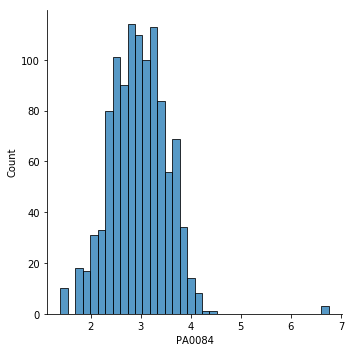

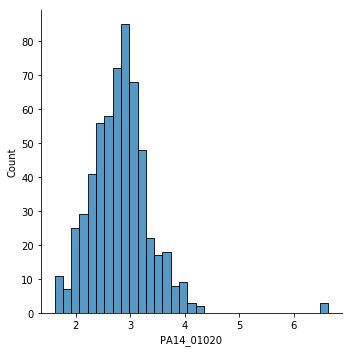

In [50]:
sns.displot(np.log10(pao1_expression.loc[pao1_select_id]))
sns.displot(np.log10(pa14_expression.loc[pa14_homolog_id]))